<a href="https://colab.research.google.com/github/pinkesh-ai/astsin/blob/main/Brain_Tumour_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumour Diagnosis

### Imports and setup

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 7.9 MB/s 
     |████████████████████████████████| 188 kB 16.6 MB/s 
     |████████████████████████████████| 46 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 29.7 MB/s 
     |████████████████████████████████| 53 kB 2.8 MB/s 
     |████████████████████████████████| 51 kB 379 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


### Loading the dataset from Kaggle

In [4]:
!pip install kaggle

In [5]:
%cd //content/gdrive/MyDrive

/content/gdrive/MyDrive


In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [7]:
!kaggle datasets download -d denizkavi1/brain-tumor

brain-tumor.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
ls

 Aircsin.ipynb   Brain/   brain-tumor.zip  'Colab Notebooks'/   Kaggle/


###Data Preparation

In [9]:
!unzip //content/gdrive/MyDrive/brain-tumor.zip -d /content/gdrive/MyDrive/Brain/dev/null

Archive:  //content/gdrive/MyDrive/brain-tumor.zip
checkdir:  cannot create extraction directory: /content/gdrive/MyDrive/Brain/dev/null
           No such file or directory


###Define a Path

In [10]:
path = '/content/gdrive/MyDrive/Brain'

In [11]:
Tumor_types = '1.Meningioma', '2.Glioma', '3.Pituitary tumor'
Path = '/content/gdrive/MyDrive/Brain/'

fns = get_image_files(path)

In [12]:
fns = get_image_files(path)
fns

(#3064) [Path('/content/gdrive/MyDrive/Brain/1.Meningioma /2301.png'),Path('/content/gdrive/MyDrive/Brain/1.Meningioma /2300.png'),Path('/content/gdrive/MyDrive/Brain/1.Meningioma /2310.png'),Path('/content/gdrive/MyDrive/Brain/1.Meningioma /2319.png'),Path('/content/gdrive/MyDrive/Brain/1.Meningioma /2303.png'),Path('/content/gdrive/MyDrive/Brain/1.Meningioma /2327.png'),Path('/content/gdrive/MyDrive/Brain/1.Meningioma /2318.png'),Path('/content/gdrive/MyDrive/Brain/1.Meningioma /2324.png'),Path('/content/gdrive/MyDrive/Brain/1.Meningioma /2320.png'),Path('/content/gdrive/MyDrive/Brain/1.Meningioma /2317.png')...]

In [15]:
failed = verify_images(fns)
failed

(#0) []

In [16]:
failed.map('Path.unlink');

In [17]:
Brains='/content/gdrive/MyDrive/Brain'

In [18]:
Brains = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [19]:
blocks=(ImageBlock, CategoryBlock)

In [20]:
dls = Brains.dataloaders(path)

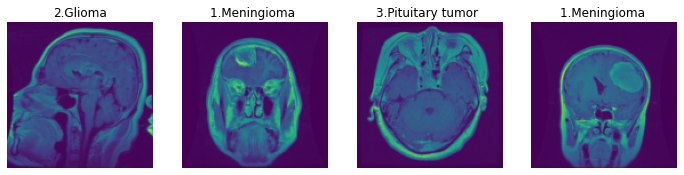

In [21]:
dls.valid.show_batch(max_n=4, nrows=1)

###Trining Model without touching Images

In [58]:
#learn = cnn_learner(dls, resnet18, metrics=error_rate)
#learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,06:49


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:40
1,0.000000,0.000000,0.000000,00:41
2,0.000000,0.000000,0.000000,00:39
3,0.000000,0.000000,0.000000,00:41


#### Experimented with Images

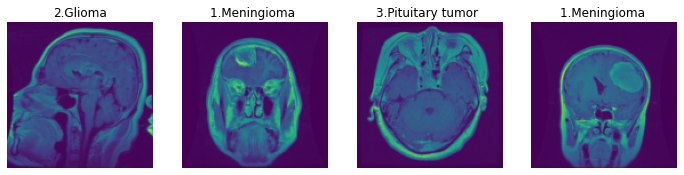

In [22]:
#Squish
Brains = Brains.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = Brains.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
#pad
Brains = Brains.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros')
dls = Brains.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
#RandomResizedCrop
#Brains = Brains.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
#dls = Brains.dataloaders(path)
#dls.train.show_batch(max_n=4, nrows=1, unique=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


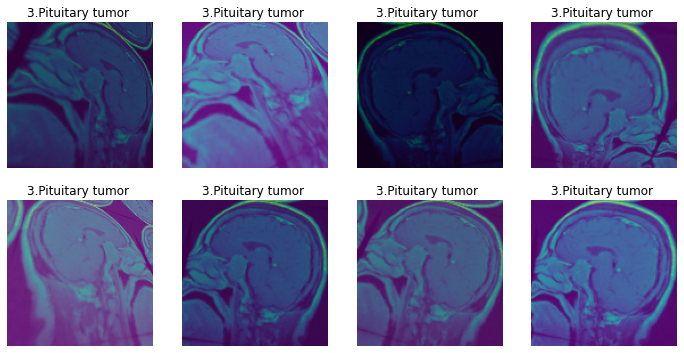

In [24]:
#transforms
Brains = Brains.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = Brains.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

###Trining Model after modifying Images

In [25]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.261397,0.568508,0.187909,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.772189,0.410874,0.151961,00:40
1,0.635285,0.352228,0.112745,00:40
2,0.502220,0.291682,0.109477,00:39
3,0.416938,0.274027,0.099673,00:40


###Interpretation

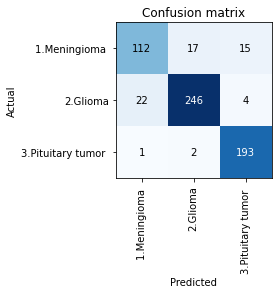

In [26]:
#Interpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

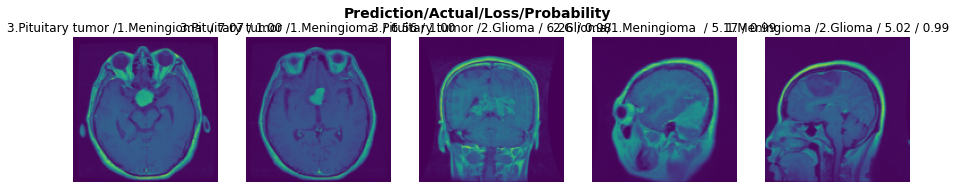

In [27]:
#toploss
interp.plot_top_losses(5, nrows=1)

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [32]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)